In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rcParams
rcParams['legend.fontsize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14

%matplotlib inline

# Dynamics of INS errors

This example analyses the behaviour of errors of an Inertial Navigation System. The errors (as long as they small enough) are described by a system of linear ODEs. When the system matrix is constant (INS resting on bench, straight flight at a constant speed) the system can be solved in a closed formed, but even in this case it is a cumbersome procedure. So pyins provides a simple routine for numerical propagation of INS errors.

## Generate Trajectory

We will use a straight and level flight as a trajectory. We are going to generate data for 48 hours to consider a long term behaviour of the errors. 

In [2]:
from pyins import sim

Because we are not going to use IMU readings we set high sampling period.

In [3]:
dt = 1

We specify the trajectory with time series of latitudes and longitudes and corresponding time stamps. For simplicity, we consider the flight in the East direction. This situation is largely similar to static conditions, but nevertheless more interesting as it contains heading to position errors coupling due to motion.

In [4]:
n_samples = 3600*48
lat = np.tile(40.714, n_samples)
lon = np.linspace(-74.006, 100, n_samples)
alt = np.tile(0, n_samples)
h = np.tile(90, n_samples)
p = np.tile(0, n_samples)
r = np.tile(0, n_samples)

traj, gyro, accel = sim.from_position(dt, lat, lon, alt, h, p, r)

The trajectory is drawn below, the initial point is marked with a cross.

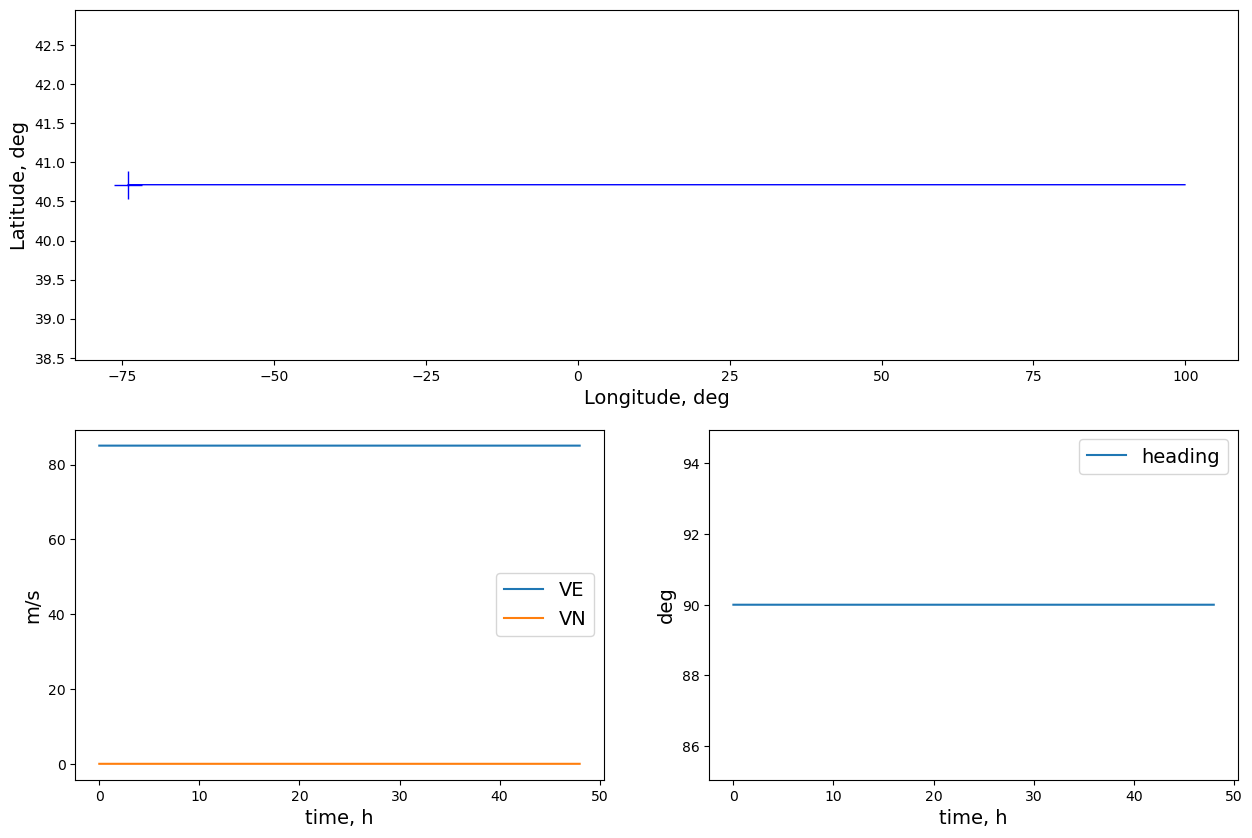

In [5]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(traj.lon[::60], traj.lat[::60],
        linewidth=1,
        color='blue')
ax.plot(traj.lon[0], traj.lat[0],
        markersize=20,
        marker='+',
        color='blue')
ax.set_xlabel("Longitude, deg")
ax.set_ylabel("Latitude, deg")

ax = fig.add_subplot(gs[1, 0])
ax.plot(traj.index * dt / 3600, traj.VE, label='VE')
ax.plot(traj.index * dt / 3600, traj.VN, label='VN')
ax.set_xlabel("time, h")
ax.set_ylabel("m/s")
ax.legend()

ax = fig.add_subplot(gs[1, 1])
ax.plot(traj.index * dt / 3600, traj.h, label='heading')
ax.set_xlabel("time, h")
ax.set_ylabel("deg")
ax.legend()

plt.show()

On the plots we see that the velocity as well as the heading are constant.

## Eigenvalues of the system

In our case the system matrix is constant, so we can analyze its behaviour by finding the eigenvalues. Here we will use a private function which are not generally intended to use from a user side.

In [6]:
from pyins.filt import _error_model_matrices
from numpy import linalg as LA

In [7]:
F = _error_model_matrices(traj.iloc[:1])[0][0]

In [8]:
eigvals, eigvecs = LA.eig(F)
eigvals

array([-8.41844093e-20+1.29951383e-03j, -8.41844093e-20-1.29951383e-03j,
        1.73920315e-19+1.18142251e-03j,  1.73920315e-19-1.18142251e-03j,
        3.49592560e-23+0.00000000e+00j, -1.38620587e-20+9.05214438e-05j,
       -1.38620587e-20-9.05214438e-05j])

So we see that all eigenvalues come in complex conjugate pairs and in fact they are imaginary (the real parts are numerical errors). It means that all modes are bounded and oscillatory. The periods are: 81.7 minutes, 87.3 minutes and 21.3 hours. The first two are slightly perturbed so called Schuller period, which is nominally 84 minutes. The last one is related to Earth rotation, but since our vehicle is moving in East direction it completes the rotation in 21.3 hours.

## Example of errors propagation without sensor errors

Here we illustrates the previous findings by computing the **errors solution for some initial values**.

In [9]:
from pyins.filt import propagate_errors
from pyins import earth

In [10]:
%%time
err = propagate_errors(dt, traj, d_lat=500, d_lon=-300, d_VE=2, d_VN=-1, d_h=0.05, d_p=0.01, d_r=-0.02)

Wall time: 3.17 s


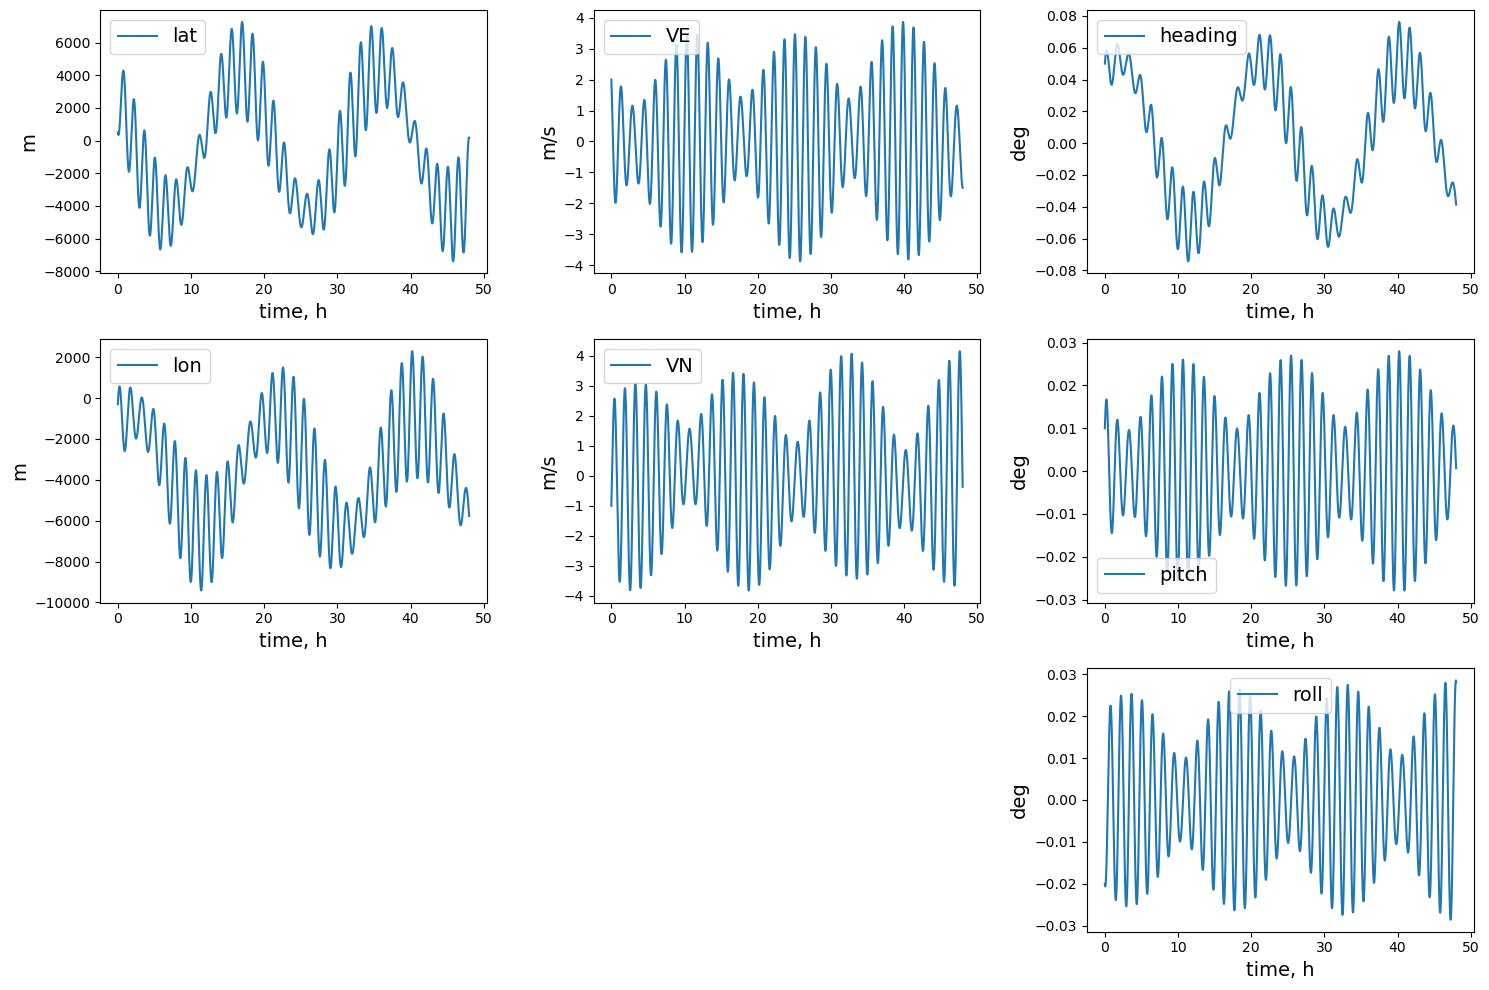

In [11]:
from helper import plot_traj
plot_traj(dt, err, time_unit="h", coord_unit="m")

It's easy to compute responses to individual error sources and thus compute the full transition matrix. But it will be hard and cumbersome to illustrate such result. 

A simpler way is to repeat computations with some initial errors disabled and compare the results with the full picture. By such approach the following conclusions can be easily verified:

1. An initial longitude error doesn't excite other errors and doesn't evolve itself. It means that it's impossible to distinguish between different values of longitude and the navigation can be started from any value.
2. An initial latitude error doesn't influence other errors significantly.
3. Velocity, pitch and roll errors form a subsystem weakly influenced by other errors.
4. Heading error is mostly determined by initial heading, pitch and roll errors.

Note that 2, 3, 4 are true as long as $\Delta r / R$ ($\Delta r$ is the position error and $R$ is Earth radius) is significantly less than attitude errors.

## Errors due accelerometer biases

Now we investigate errors propagation when the inertial sensors containing constant biases.

We consider errors due to the **East accelerometer bias** (keep in mind that the attitude is constant and the heading is 90 degrees).

In [12]:
err = propagate_errors(dt, traj, d_accel=[0, 1e-2, 0])

We see that accelerometer biases also creates oscillatory errors. The things worth noting are that longitude, pitch and heading errors are biased relative to zero by their oscillation amplitudes. 

Errors due to the North bias are conceptually the same, with East and North axes switched. The heading error won't have a bias.

Errors due to the vertical accelerometer bias is irrelevant for horizontal errors components.

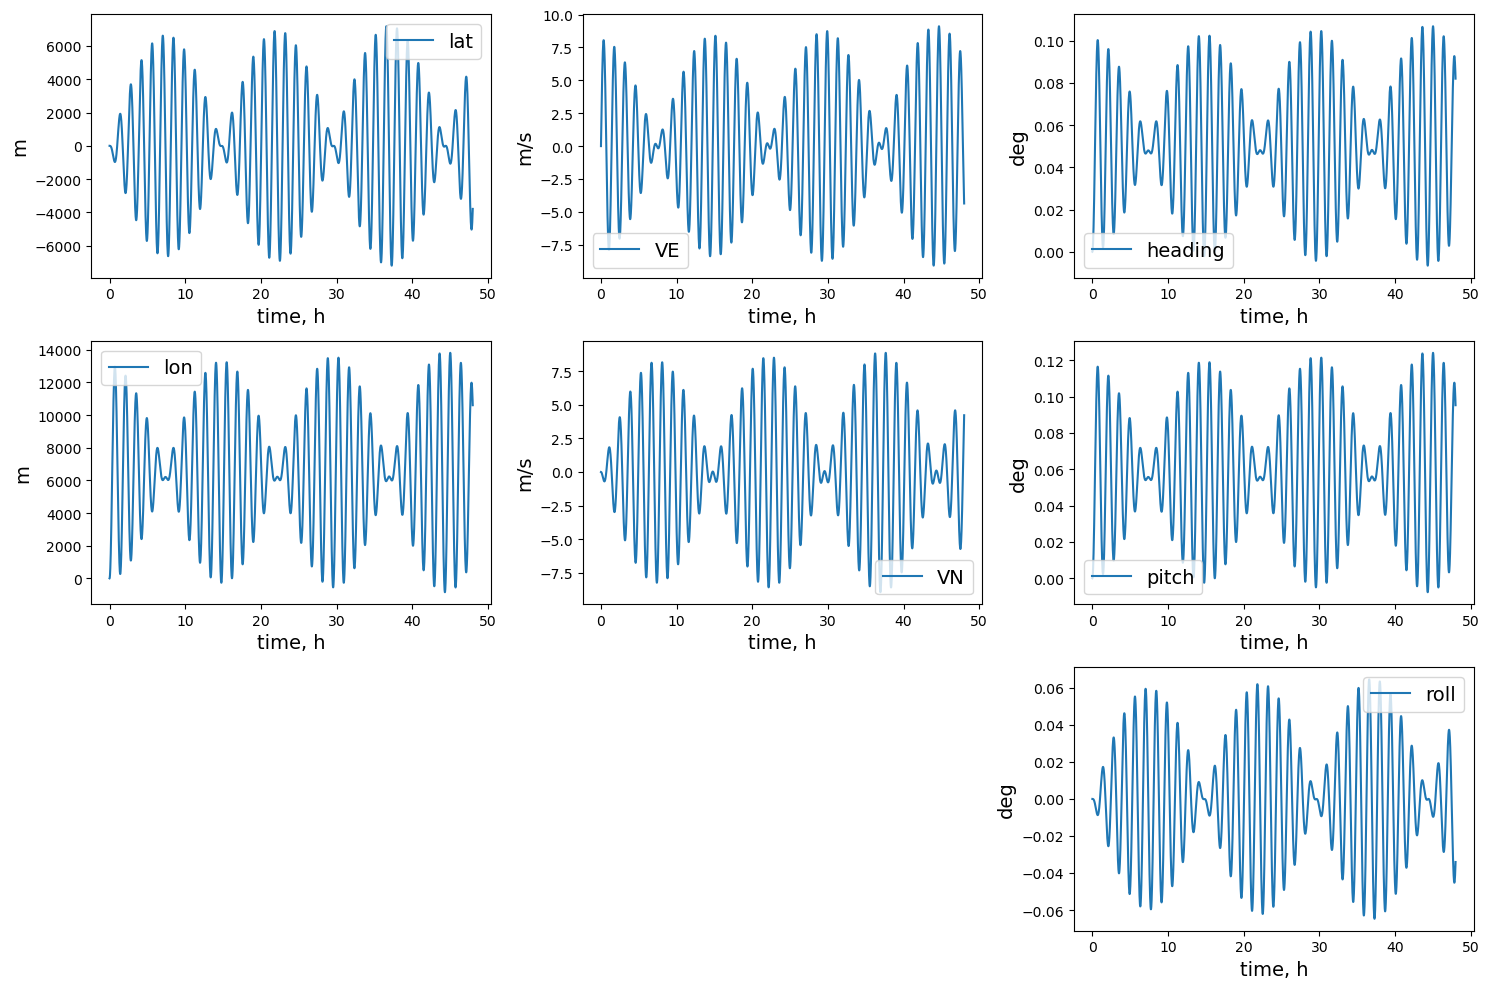

In [13]:
plot_traj(dt, err, time_unit="h", coord_unit="m")

We can display these errors on a map :

In [14]:
from pyins.coord import perturb_ll
lat, lon = perturb_ll(traj.lat, traj.lon, err.lat, err.lon)

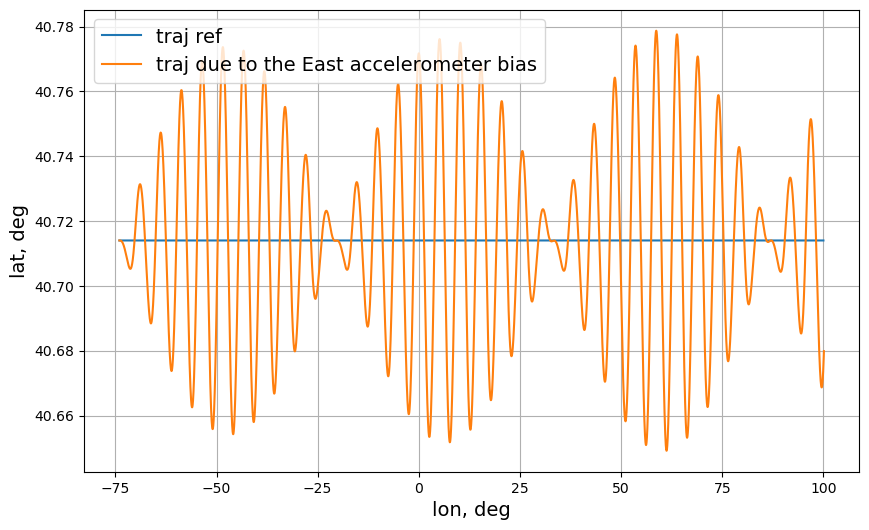

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(traj.lon, traj.lat, label='traj ref')
plt.plot(lon, lat, label='traj due to the East accelerometer bias')
plt.grid()
plt.legend(loc='best')
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")
plt.show()

## Errors due to gyroscope biases

First consider errors due to the **East gyro bias**.

In [16]:
err = propagate_errors(dt, traj, d_gyro=[0, 1e-7, 0])

We see that errors are bounded, with longitude and heading errors biased by the value of their amplitudes.

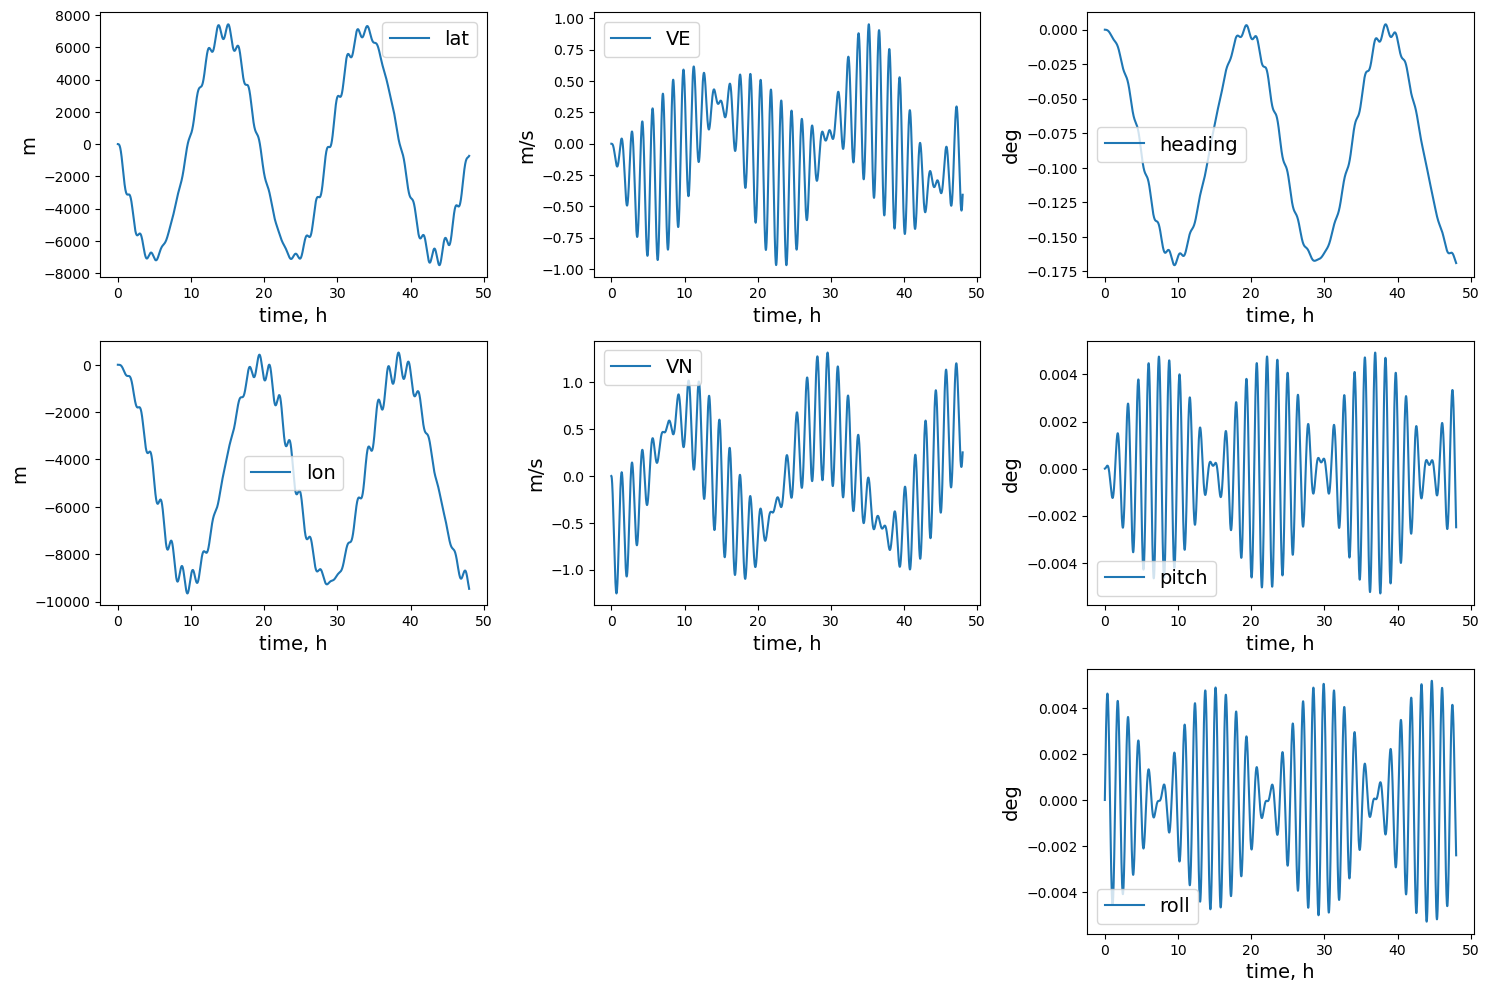

In [17]:
plot_traj(dt, err, time_unit="h", coord_unit="m")

Now consider errors due to the **North bias**.

In [18]:
err = propagate_errors(dt, traj, d_gyro=[+1e-7, 0, 0])  # North bias is +1e-7.

This is the first case when the error in longitude growth approximately linearly to an unbounded value. The rate of the longitude error growth is $R \epsilon_N \cos^2 \varphi$ , where $\varphi$ is the latitude and $\epsilon$ is the North gyro bias. 

In our case the growth in kilometers per hour is equal to:

In [19]:
1e-7 * earth.R0 * 3.6 * np.cos(np.deg2rad(traj.lat[0])) ** 2

1.3191861407523435

So the expected final error is 1.72 * 48 = 82.5 km, which matches well with the simulation results.

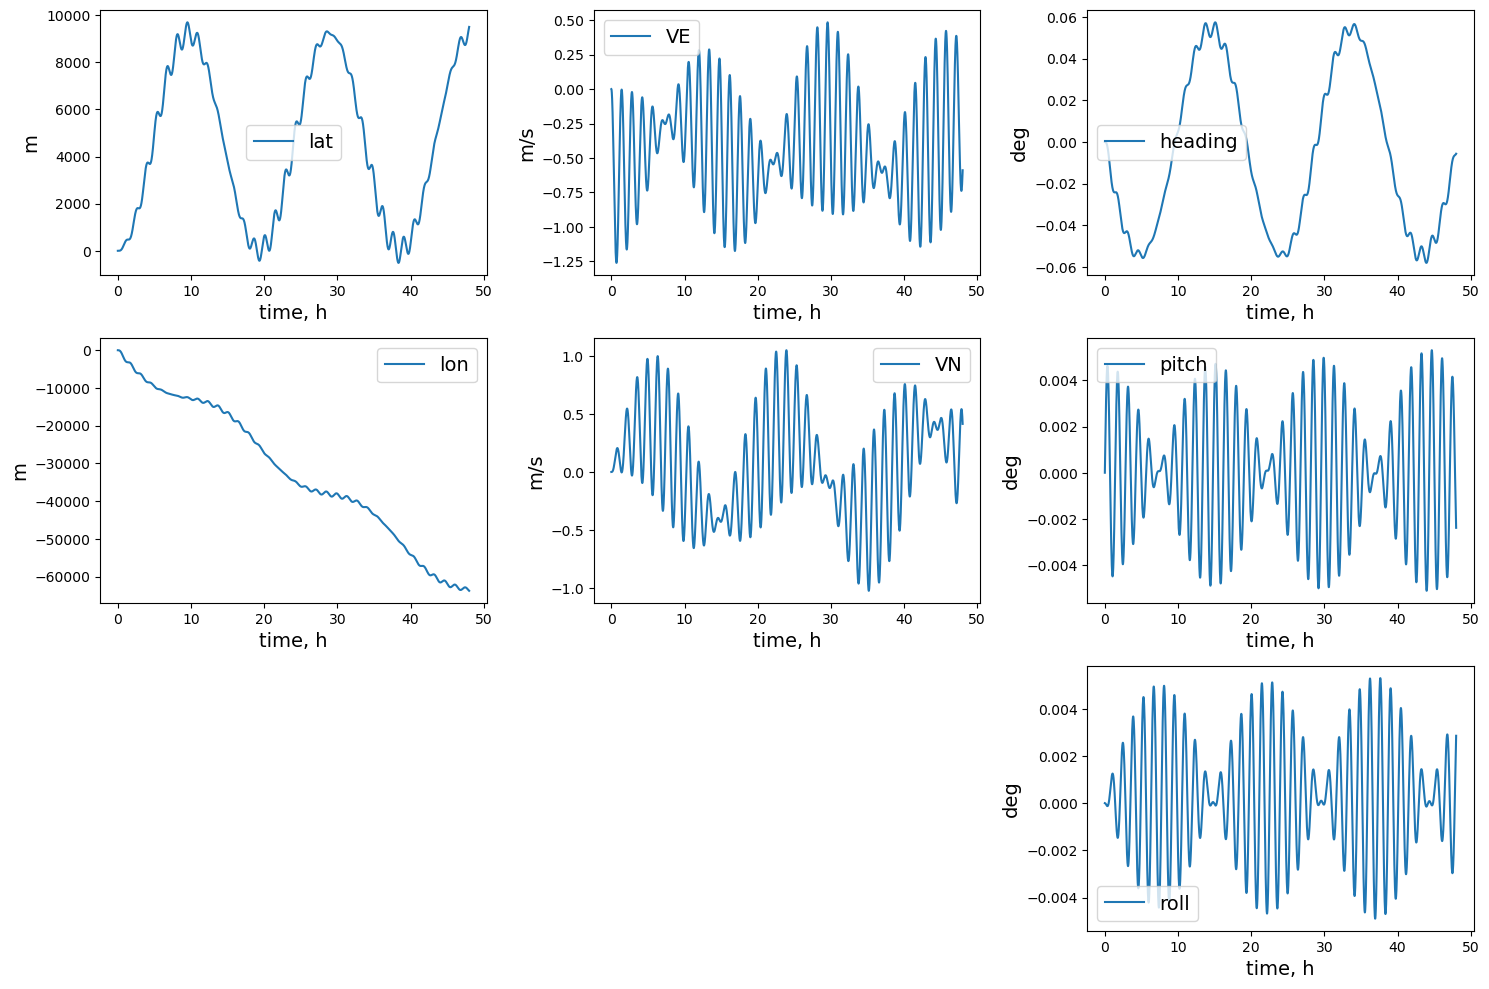

In [20]:
plot_traj(dt, err, time_unit="h", coord_unit="m")

Now consider errors due to the **vertical bias**.

In [21]:
err = propagate_errors(dt, traj, d_gyro=[0, 0, 1e-7]) 

In this case the longitude error also growths unbounded. The rate of growth is equal to $R \epsilon_N \sin \varphi \cos \varphi$:

In [22]:
1e-7 * earth.R0 * 3.6 * np.sin(np.deg2rad(traj.lat[0])) * np.cos(np.deg2rad(traj.lat[0]))

1.1352400197165535

And the expected final error is 0.99 * 48 = 47.5 km. The simulation value is slightly lower because of sinusoidal modulations.

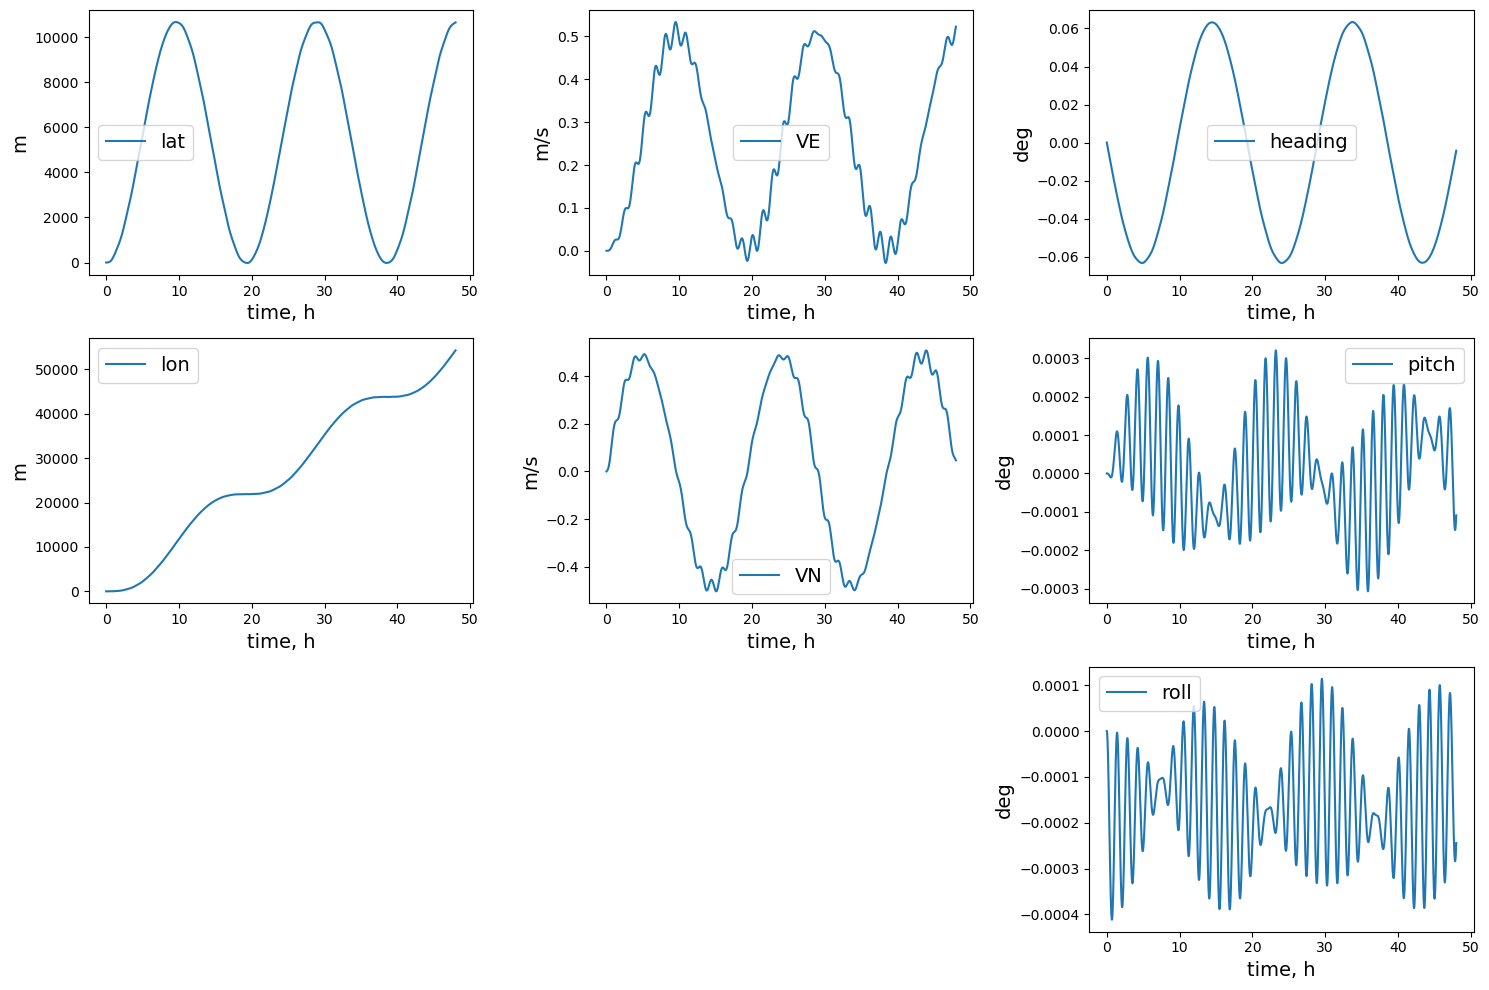

In [23]:
plot_traj(dt, err, time_unit="h", coord_unit="m")

We can display these errors on a map :

In [24]:
from pyins.coord import perturb_ll
lat, lon = perturb_ll(traj.lat, traj.lon, err.lat, err.lon)

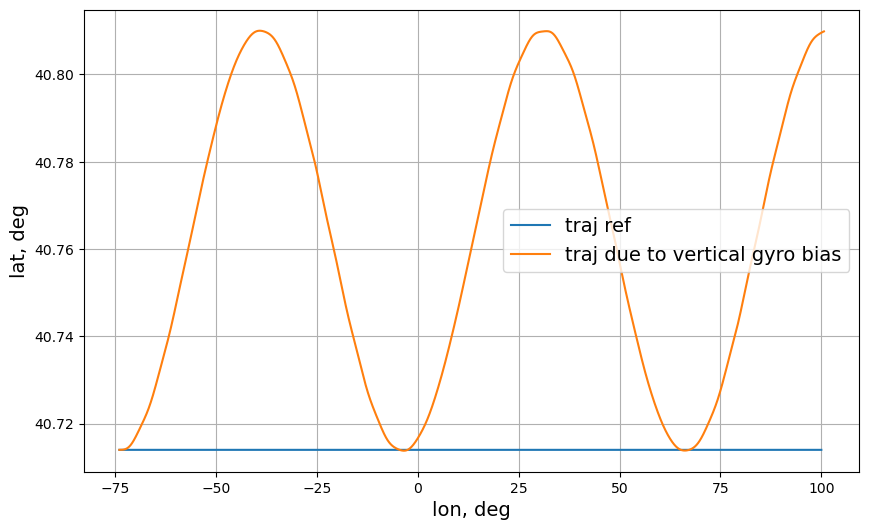

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(traj.lon, traj.lat, label='traj ref')
plt.plot(lon, lat, label='traj due to vertical gyro bias')
plt.grid()
plt.legend(loc='best')
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")
plt.show()

## Conclusion

When the coefficients of the error equations are constant, then:

1. The horizontal INS errors contain only oscillatory modes. The two periods are 24 hours (corrected by a vehicle East velocity) and the 84 minutes (slightly perturbed depending on a latitude and a vehicle's velocity).
2. The response to constant accelerometer biases is also bounded and oscillatory. The same holds true for a constant East gyro bias.
3. In a presence of North and vertical gyro biases the longitude error growths unbounded, with the rate of growth proportional to $R \varepsilon$. And this is the only unbounded error. It proves the fact that the **pure inertial performance of an INS is determined by gyroscopes accuracy**.

Generally the behaviour of INS errors can be analyzed at any level of detail and for arbitrary trajectories using pyins.